# 📌 SMS Spam Detection using Word2Vec and Bidirectional LSTM

##📝 Introduction
This project solves the problem of differentiating spam messages from genuine ones based on Natural Language Processing (NLP) and Deep Learning. The dataset employed is the widely used SMS Spam Collection, which consists of thousands of labelled text messages as either "ham" (not spam) or "spam."

The process involves:

-- Text preprocessing: Lowercasing, punctuation and number removal, tokenisation

-- Word embedding: Training a Word2Vec model to convert text to numerical vectors

-- Deep learning model: Building a Bidirectional LSTM model to capture contextual patterns in messages

-- Evaluation: Assessing the model's accuracy on unseen data

Through the use of deep learning and distributed word representations, this project illustrates a robust method for spam detection in messaging systems.

In [3]:
# Imorting Libraries
import pandas as pd
import re
import string

In [4]:
df = pd.read_csv(r"C:/Users/nihar/Desktop/SMS Spam Collection/SMSSpamCollection", sep='\t', names=['label', 'message'])

In [5]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.shape

(5572, 2)

In [7]:
# Looking for any null data
df.isnull().sum()

label      0
message    0
dtype: int64

In [8]:
# Pre-preocessing the data
import re
import string

def preprocess(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

df['cleaned'] = df['message'].apply(preprocess)


In [9]:
# Convert categorical labels to binary values: ham → 0, spam → 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [10]:
## Get the Independent Features
X=df.drop('label',axis=1)

In [11]:
## Get the Dependent features
y=df['label']

In [12]:
X.shape

(5572, 2)

In [13]:
y.shape

(5572,)

In [14]:
import tensorflow as tf
tf.__version__

'2.19.0'

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

### Tokenization

In [17]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

df['tokens'] = df['cleaned'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nihar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [18]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)

In [19]:
import numpy as np

# Function to compute the average Word2Vec embedding for a list of words
def get_avg_vector(words, model, k=100):
    vec = np.zeros(k)
    count = 0
    for word in words:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count != 0 else vec

# Apply average vector computation to each tokenized message
df['avg_vec'] = df['tokens'].apply(lambda x: get_avg_vector(x, w2v_model))

X = np.stack(df['avg_vec'].values)
y = df['label'].values


In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned'])
sequences = tokenizer.texts_to_sequences(df['cleaned'])

vocab_size = len(tokenizer.word_index) + 1

### Embedding Representation

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 50

X_seq = pad_sequences(sequences, maxlen=maxlen)
y = df['label'].values

In [23]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


In [24]:
## Creating model

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

C:\Users\nihar\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       870,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 870,800 (3.32 MB)

 Trainable params: 870,800 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)

In [26]:
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]


### Model Training

In [28]:
## Finally Training
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks  # ← this is the key line!
)


Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8842 - loss: 0.3375 - val_accuracy: 0.9794 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9756 - loss: 0.0855 - val_accuracy: 0.9874 - val_loss: 0.0459 - learning_rate: 0.0010
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9907 - loss: 0.0350 - val_accuracy: 0.9892 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9955 - loss: 0.0186 - val_accuracy: 0.9901 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9988 - loss: 0.0053 - val_accuracy: 0.9901 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9980 - loss: 0.0094 - val_accuracy: 0.9901 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9987 - loss: 0

### Performance Metrics And Accuracy

In [30]:
y_pred=model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [31]:
# Make predictions on the test set
y_pred=np.where(y_pred > 0.5, 1,0)

# Check the accuracy and generate the classification report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Classification report (precision, recall, f1-score)
report = classification_report(y_test, y_pred, target_names=["ham", "spam"])

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

accuracy, report, cm


(0.9937219730941704,
 '              precision    recall  f1-score   support\n\n         ham       0.99      1.00      1.00       966\n        spam       1.00      0.95      0.98       149\n\n    accuracy                           0.99      1115\n   macro avg       1.00      0.98      0.99      1115\nweighted avg       0.99      0.99      0.99      1115\n',
 array([[966,   0],
        [  7, 142]], dtype=int64))

In [32]:
# Create a dataframe for the confusion matrix
cm_df = pd.DataFrame(cm, index=["Ham", "Spam"], columns=["Pred_Ham", "Pred_Spam"])

# Print accuracy and confusion matrix
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(cm_df)


Accuracy: 0.9937219730941704

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       966
        spam       1.00      0.95      0.98       149

    accuracy                           0.99      1115
   macro avg       1.00      0.98      0.99      1115
weighted avg       0.99      0.99      0.99      1115


Confusion Matrix:
      Pred_Ham  Pred_Spam
Ham        966          0
Spam         7        142


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


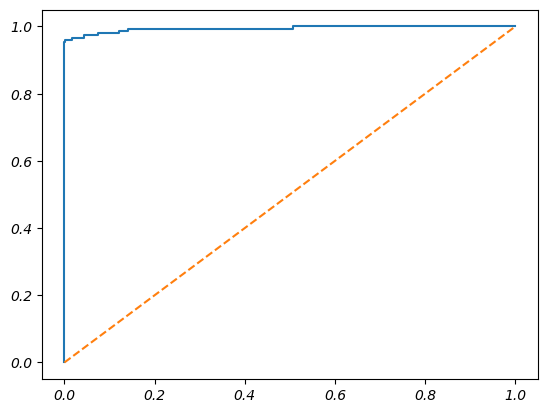

In [33]:
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# Get predictions and convert to binary
y_pred_probs = model.predict(X_test) # Predictions are probabilities
y_pred = (y_pred_probs > 0.5).astype(int) # Convert to 0 or 1 based on threshold

# Plot ROC curve (still using probabilities)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.show()

### ✅ Conclusion
Through this project, we successfully developed a deep learning-based model for SMS spam classification. After thorough text preprocessing and training a Word2Vec embedding on the tokenized data, we used a Bidirectional LSTM network to classify messages. This model effectively captured the sequential nature and semantic context of the text data, achieving strong performance in distinguishing spam from ham messages.

Key highlights:

-- Used custom-trained Word2Vec embeddings instead of pre-trained ones

-- Built a neural network with an embedding layer initialized by Word2Vec vectors

-- Achieved accurate classification with LSTM's ability to retain contextual meaning

This end-to-end NLP pipeline forms a robust baseline for spam filtering. Further work could explore:

-- Using pre-trained embeddings like GloVe

-- Incorporating attention mechanisms

-- Experimenting with other architectures like GRU or Transformer-based models